In [27]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.util.systems import system_from_str
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import assess_constraints
import seaborn as sns
import pandas as pd
import warnings
import scipy
from dsn.util import fct_mf as mf
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
system_str = 'V1_circuit';
system_dir = 'V1_circuit_SV';

behavior_str = 'ss_all';
param_str = 'h';

basedir = '/Users/sbittner/Documents/dsn/dsn/results/';

In [43]:
sample_str = 'file';

if (sample_str == 'grid'):
    # create test parameter grid
    bound = 2.0;
    start = 0.0;
    stop = bound;
    res = 0.5;
    eps = .001*res;
    vals = np.arange(start, stop+eps, res);
    num_pts = vals.shape[0];

    total_pts = num_pts**8;
    params = np.zeros((total_pts,8));
    ind = 0;
    for i in range(num_pts):
        h_E1 = vals[i];
        for j in range(num_pts):
            h_P1 = vals[j];
            for k in range(num_pts):
                h_S1 = vals[k];
                for l in range(num_pts):
                    h_V1 = vals[l];
                    for ii in range(num_pts):
                        h_E2 = vals[ii];
                        for jj in range(num_pts):
                            h_P2 = vals[jj];
                            for kk in range(num_pts):
                                h_S2 = vals[kk];
                                for ll in range(num_pts):
                                    h_V2 = vals[ll];
                                    params[ind,:] = np.array([h_E1, h_P1, h_S1, h_V1, \
                                                              h_E2, h_P2, h_S2, h_V2]);
                                    ind += 1;
    print(params.shape);
    
elif (sample_str == 'file'):
    nlayers = 10;
    sigma_init = 1.0;
    c_init = -4;
    rs = 4;
        
    savedir = basedir + system_dir + '/' \
      'V1_circuit_D=8_flow=M_%dP_sigma=%.2f_lr_order=-3_c=%d_rs=%d/' % \
      (nlayers, sigma_init, c_init, rs);
    fname = savedir + 'results.npz';
    alpha = 0.05;
    npzfile = np.load(fname);
    phis = npzfile['phis'];
    T_phis = npzfile['T_phis'];
    n_suff_stat_train = T_phis.shape[2];
    mu = npzfile['mu'];
    k_max = phis.shape[0]-1;
    p_values, AL_final_its = assess_constraints([fname], alpha, k_max, mu, n_suff_stat_train);
    
    AL_final_it = AL_final_its[0];
    print(AL_final_it, phis.shape)
    params = phis[AL_final_it,:,:];
    print(params.shape);
    total_pts = params.shape[0];

else: # random
    total_pts = 10000;
    params = np.zeros((total_pts,8));
    x = np.random.normal(0,1.0,(total_pts,8));
    params = np.log(1+np.exp(x));
    

8 (21, 1000, 8)
(1000, 8)


phi (1, ?, 8)
phi (1, ?, 8)
phi (1, ?, 8)


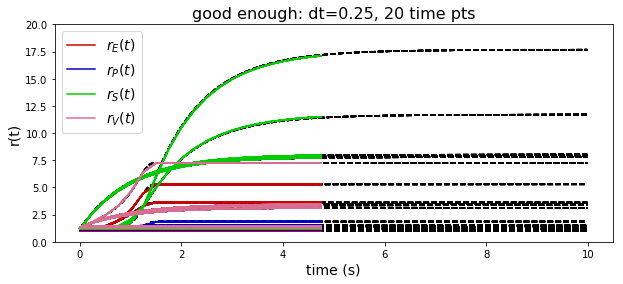

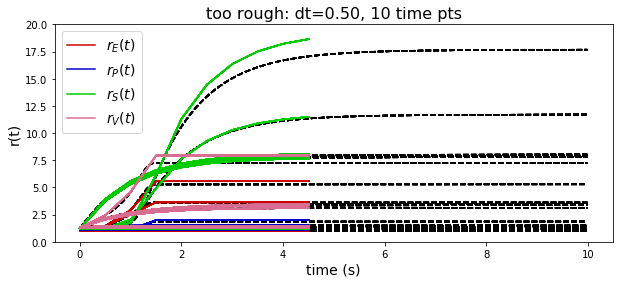

In [44]:
# test convergence at extreme input points
start = 0;
stop = 2;
conv_test_pts = 2**8;    
vals = [start, stop];
conv_test_params = np.zeros((conv_test_pts, 8));
ind = 0;
for i in range(2):
    h_E1 = vals[i];
    for j in range(2):
        h_P1 = vals[j];
        for k in range(2):
            h_S1 = vals[k];
            for l in range(2):
                h_V1 = vals[l];
                for ii in range(2):
                    h_E2 = vals[ii];
                    for jj in range(2):
                        h_P2 = vals[jj];
                        for kk in range(2):
                            h_S2 = vals[kk];
                            for ll in range(2):
                                h_V2 = vals[ll];
                                conv_test_params[ind,:] = np.array([h_E1, h_P1, h_S1, h_V1, \
                                                                    h_E2, h_P2, h_S2, h_V2]);
                                ind += 1;

init_conds = np.expand_dims(np.array([1.0, 1.1, 1.2, 1.3]), 1);
system_class = system_from_str(system_str);
T_gt = 1000;
dt_gt = 0.01;
t_gt = np.arange(0, dt_gt*T_gt, dt_gt);
system_gt = system_class(behavior_str, param_str, T_gt, dt_gt, init_conds);

T_rough = 10;
dt_rough = 0.5;
system_rough = system_class(behavior_str, param_str, T_rough, dt_rough, init_conds);
t_rough = np.arange(0, dt_rough*T_rough, dt_rough);

T = 20;
dt = 0.25;
system = system_class(behavior_str, param_str, T, dt, init_conds);
t = np.arange(0, dt*T, dt);

num_params = system.D;
K = 1;
phi = tf.placeholder(dtype=tf.float64, shape=(K, None, num_params, 1));

r1_t, r2_t = system.simulate(phi);
r1_t_gt, r2_t_gt = system_gt.simulate(phi);
r1_t_rough, r2_t_rough = system_rough.simulate(phi);

_phi = np.expand_dims(np.expand_dims(conv_test_params, 0), 3);

with tf.Session() as sess:
    _r1_t, _r2_t, _r1_t_gt, _r2_t_gt, _r1_t_rough, _r2_t_rough \
           = sess.run([r1_t, r2_t, r1_t_gt, r2_t_gt, r1_t_rough, r2_t_rough], \
                      {phi:_phi});

fontsize = 14;
red = [.8, 0, 0];
blue = [0, 0, .8];
green = [0, .8, 0];
pink = [.85, .43, .58];
ymax = 20.0;

# plot used
plt.figure(figsize=(10,4));

plt.plot(t, _r1_t[:,0,0,0,0], c=red, label=r'$r_E(t)$');
plt.plot(t, _r1_t[:,0,0,1,0], c=blue, label=r'$r_P(t)$');
plt.plot(t, _r1_t[:,0,0,2,0], c=green, label=r'$r_S(t)$');
plt.plot(t, _r1_t[:,0,0,3,0], c=pink, label=r'$r_V(t)$');

plt.plot(t_gt, _r1_t_gt[:,0,:,0,0], 'k--');
plt.plot(t_gt, _r1_t_gt[:,0,:,1,0], 'k--');
plt.plot(t_gt, _r1_t_gt[:,0,:,2,0], 'k--');
plt.plot(t_gt, _r1_t_gt[:,0,:,3,0], 'k--');

plt.plot(t, _r1_t[:,0,:,0,0], c=red);
plt.plot(t, _r1_t[:,0,:,1,0], c=blue);
plt.plot(t, _r1_t[:,0,:,2,0], c=green);
plt.plot(t, _r1_t[:,0,:,3,0], c=pink);

plt.xlabel('time (s)', fontsize=fontsize);
plt.ylabel('r(t)', fontsize=fontsize);
plt.ylim([0, ymax]);
plt.legend(fontsize=fontsize);
plt.title('good enough: dt=%.2f, %d time pts' % (dt, T), fontsize=fontsize+2);
plt.show();
    
    
# plot too rough
plt.figure(figsize=(10,4));

plt.plot(t_rough, _r1_t_rough[:,0,0,0,0], c=red, label=r'$r_E(t)$');
plt.plot(t_rough, _r1_t_rough[:,0,0,1,0], c=blue, label=r'$r_P(t)$');
plt.plot(t_rough, _r1_t_rough[:,0,0,2,0], c=green, label=r'$r_S(t)$');
plt.plot(t_rough, _r1_t_rough[:,0,0,3,0], c=pink, label=r'$r_V(t)$');

plt.plot(t_gt, _r1_t_gt[:,0,:,0,0], 'k--');
plt.plot(t_gt, _r1_t_gt[:,0,:,1,0], 'k--');
plt.plot(t_gt, _r1_t_gt[:,0,:,2,0], 'k--');
plt.plot(t_gt, _r1_t_gt[:,0,:,3,0], 'k--');

plt.plot(t_rough, _r1_t_rough[:,0,:,0,0], c=red);
plt.plot(t_rough, _r1_t_rough[:,0,:,1,0], c=blue);
plt.plot(t_rough, _r1_t_rough[:,0,:,2,0], c=green);
plt.plot(t_rough, _r1_t_rough[:,0,:,3,0], c=pink);

plt.xlabel('time (s)', fontsize=fontsize);
plt.ylabel('r(t)', fontsize=fontsize);
plt.ylim([0, ymax]);
plt.legend(fontsize=fontsize);
plt.title('too rough: dt=%.2f, %d time pts' % (dt_rough, T_rough), fontsize=fontsize+2);
plt.show();

In [45]:
T_a = system.simulation_suff_stats(phi);

_phi = np.expand_dims(np.expand_dims(params, 0), 3);

with tf.Session() as sess:
    _T_a = sess.run(T_a, {phi:_phi});

"""mu = np.array([1.0, 0.25, 1.0, 0.0]);
Sigma = np.array([0.05, 0.05, 0.05, 0.05]);
behavior = {'mu':mu, 'Sigma':Sigma};

_mu = system.compute_mu(behavior);

nsamps = _phi.shape[1];
distance = np.zeros((nsamps,));
for i in range(nsamps):
    distance[i] = np.linalg.norm(_T_a[0,i,:4] - _mu[:4]);"""

phi (1, ?, 8)
(?, ?, 4) (?, ?, 4) (?, ?, 8)


"mu = np.array([1.0, 0.25, 1.0, 0.0]);\nSigma = np.array([0.05, 0.05, 0.05, 0.05]);\nbehavior = {'mu':mu, 'Sigma':Sigma};\n\n_mu = system.compute_mu(behavior);\n\nnsamps = _phi.shape[1];\ndistance = np.zeros((nsamps,));\nfor i in range(nsamps):\n    distance[i] = np.linalg.norm(_T_a[0,i,:4] - _mu[:4]);"

In [46]:
for i in range(system.num_suff_stats):
    Txs = _T_a[0,:,i];
    print('i=%d, min=%.4f, max=%.4f' % (i+1, np.min(Txs), np.max(Txs)));

i=1, min=-0.0329, max=5.3106
i=2, min=-45.0263, max=34.4308
i=3, min=-0.5553, max=16.0231
i=4, min=-0.8103, max=16.4297
i=5, min=0.0000, max=28.2025
i=6, min=0.0000, max=2027.3648
i=7, min=0.0000, max=256.7411
i=8, min=0.0000, max=269.9337


0.054961158154748925 0
3.242514610533647 0
0.47244073428032174 0
0.025174217169626898 0
0.052649066020951936 0
133.625513522026 0
0.7315444231524071 0
0.28913357279979796 0


<Figure size 864x864 with 0 Axes>

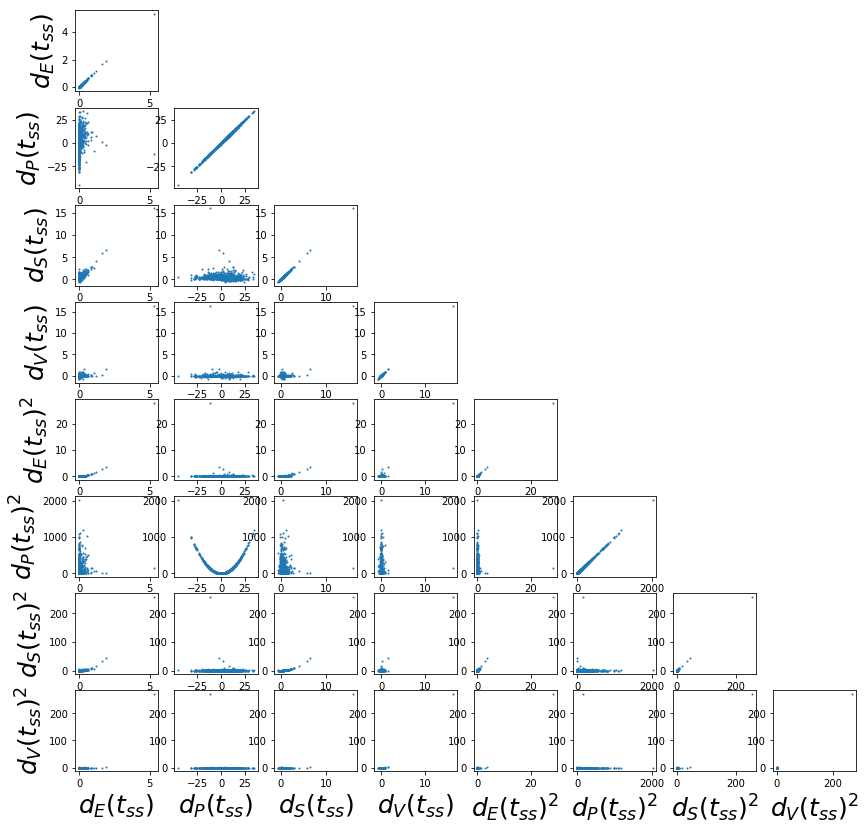

In [47]:
figsize = (12,12);
fontsize = 12;
plt.figure(figsize=figsize);

if (behavior_str == 'ss_all'):
    labels = [r'$d_{E}(t_{ss})$', r'$d_{P}(t_{ss})$', r'$d_{S}(t_{ss})$', r'$d_{V}(t_{ss})$', \
              r'$d_{E}(t_{ss})^2$', r'$d_{P}(t_{ss})^2$', r'$d_{S}(t_{ss})^2$', r'$d_{V}(t_{ss})^2$'];
elif (behavior_str == 'ss_SV'):
    labels = [r'$r_{S,ss}$', r'$r_{V,ss}$', \
              r'$r_{S,ss}^2$', r'$r_{V,ss}^2$']
    
bound = 2;
fontsize = 25;
figsize = (14, 14);
plt.figure(figsize=figsize);
for i in range(system.num_suff_stats):
    plt.subplot(1, system.num_suff_stats, i+1);
    for j in range(system.num_suff_stats):
        ind = system.num_suff_stats*i + j + 1;
        plt.subplot(system.num_suff_stats, system.num_suff_stats, ind);
        plt.scatter(_T_a[0,:,j], _T_a[0, :, i], s=1);
        if (i==(system.D-1)):
            plt.xlabel(labels[j], fontsize=fontsize);
        if (j==0):
            plt.ylabel(labels[i], fontsize=fontsize);
        #plt.xlim([-bound, bound]);
        #plt.ylim([-bound, bound]);
    print(np.mean(_T_a[0,:,i]),0);

plt.show();



In [48]:
S_inc = np.logical_and(0.25 < _T_a[0,:,2], _T_a[0,:,2] < 0.75);
V_same = np.logical_and(-0.1 < _T_a[0,:,3], _T_a[0,:,3] < 0.1);
print(np.sum(S_inc))
print(np.sum(V_same))
slice_inds = np.logical_and(S_inc, V_same);
T_a_slice = _T_a[0,:, :];
print(T_a_slice.shape)

475
888
(1000, 8)


0.054961158154748925 0
3.242514610533647 0
0.47244073428032174 0
0.025174217169626898 0


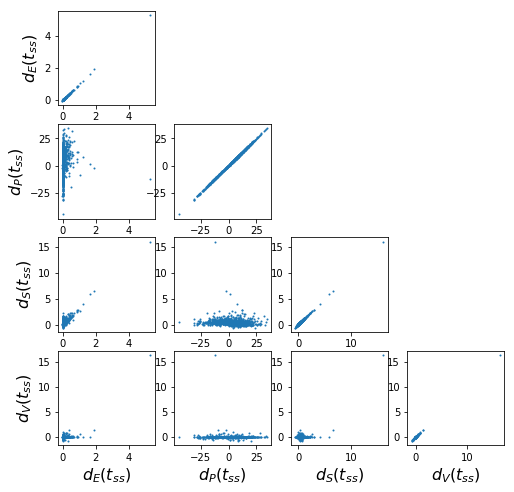

In [49]:
fontsize = 16;
figsize = (8, 8);
plt.figure(figsize=figsize);
num_plot = 4;
for i in range(num_plot):
    plt.subplot(1, num_plot, i+1);
    for j in range(num_plot):
        ind = num_plot*i + j + 1;
        plt.subplot(num_plot, num_plot, ind);
        plt.scatter(T_a_slice[:,j], T_a_slice[:,i], s=1);
        if (i==(num_plot-1)):
            plt.xlabel(labels[j], fontsize=fontsize);
        if (j==0):
            plt.ylabel(labels[i], fontsize=fontsize);
        #plt.xlim([-bound, bound]);
        #plt.ylim([-bound, bound]);
    print(np.mean(_T_a[0,:,i]),0);

plt.show();

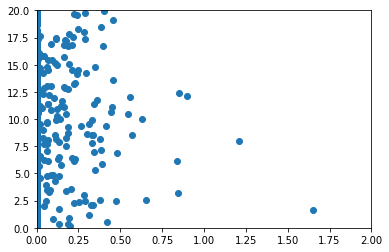

In [58]:
plt.scatter(_T_a[0,:,0], _T_a[0,:,1]);
plt.xlim([0,2]);
plt.ylim([0,20])
plt.show();